# 🚀 Model V2 — Hacettepe Datathon 2026

## Eski model (study-notebook) sorunları:
- `elapsed_time = endtime - starttime` → sabit, her satır için aynı ❌
- `bk_level = 0` satırlar filtrelenmemiş ❌
- `proses_id` hatalı hesaplanmış ❌
- `remaining_sec`, `machineid`, `is_transfer` eksik ❌
- `max_depth=3` çok sığ, `early_stopping` yok ❌
- Submission'da `Predicted.1` bug'ı ❌

## Bu notebook'ta:
- ✅ Doğru `elapsed_sec` + `remaining_sec` feature'ları
- ✅ bk_level=0 satırları filtrelendi
- ✅ Doğru proses_id (batchkey bazlı)
- ✅ 25 feature (eski: 13)
- ✅ LightGBM (XGBoost'tan daha hızlı ve genellikle daha iyi)
- ✅ Early stopping
- ✅ Temiz submission

**Beklenen MAE: ~2.5-3.5 (eski: 5.5467)**

In [1]:
# ── Kütüphaneler ──────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
try:
    import lightgbm as lgb
    USE_LGBM = True
    print('✅ LightGBM mevcut — LightGBM kullanılacak')
except ImportError:
    USE_LGBM = False
    print('⚠️  LightGBM yok, XGBoost kullanılacak')

from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error

plt.rcParams['figure.figsize'] = (14, 5)
sns.set_palette('husl')
print('✅ Kütüphaneler yüklendi')

✅ LightGBM mevcut — LightGBM kullanılacak
✅ Kütüphaneler yüklendi


In [2]:
# LightGBM yoksa kur
import subprocess, sys
if not USE_LGBM:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'lightgbm', '-q'])
    import lightgbm as lgb
    USE_LGBM = True
    print('✅ LightGBM kuruldu')

## 📦 Bölüm 1 — Veri Yükleme

In [3]:
print('⏳ Train yükleniyor...')
train_raw = pd.read_csv('train.csv', low_memory=False)
print(f'✅ Train: {train_raw.shape[0]:,} satır × {train_raw.shape[1]} sütun')

print('⏳ Test yükleniyor...')
test_raw = pd.read_csv('test.csv', low_memory=False)
print(f'✅ Test : {test_raw.shape[0]:,} satır × {test_raw.shape[1]} sütun')

sample_sub = pd.read_csv('sample_submission.csv')
print(f'✅ Sample submission: {sample_sub.shape}')
print(f'   Sütunlar: {list(sample_sub.columns)}')

⏳ Train yükleniyor...


✅ Train: 2,557,652 satır × 25 sütun
⏳ Test yükleniyor...


✅ Test : 635,133 satır × 25 sütun
✅ Sample submission: (635133, 2)
   Sütunlar: ['row_id', 'bk_level']


## 🔧 Bölüm 2 — Feature Engineering (Düzeltilmiş)

In [4]:
VALVE_COLS = [
    'bk_irtibat_valve', 'fast_dosage_valve', 'kk_irtibat_valve',
    'slow_dosage_valve', 'kk_dosage_valve', 'bk_dosage_valve', 'kk_bk_common_discharge'
]

def create_features_v2(df, is_train=True):
    df = df.copy()

    # ── Timestamp index ──────────────────────────────────────
    ts_col = 'timestamp' if 'timestamp' in df.columns else 'ztimestamp'
    if ts_col in df.columns:
        df = df.set_index(ts_col)
    df.index = pd.to_datetime(df.index, format='mixed', utc=True)
    df = df.sort_index()

    # ── Tarih sütunları ──────────────────────────────────────
    df['starttime'] = pd.to_datetime(df['starttime'], format='mixed', utc=True)
    df['endtime']   = pd.to_datetime(df['endtime'],   format='mixed', utc=True)

    # ── ✅ DOĞRU zaman feature'ları ──────────────────────────
    # elapsed_sec: proses başından geçen süre (her saniye değişir!)
    df['elapsed_sec']   = (df.index - df['starttime']).dt.total_seconds().clip(0)
    # remaining_sec: bitimine kalan süre (EDA'da r=0.76 bulmuştuk)
    df['remaining_sec'] = (df['endtime'] - df.index).dt.total_seconds().clip(0)
    # proc_dur: toplam proses süresi
    df['proc_dur']      = (df['endtime'] - df['starttime']).dt.total_seconds()
    # elapsed_pct: proses içi ilerleme yüzdesi 0-100
    df['elapsed_pct']   = (
        df['elapsed_sec'] / df['proc_dur'].replace(0, np.nan) * 100
    ).clip(0, 100)

    # ── ✅ Komut tipi feature'ları ────────────────────────────
    df['is_transfer']  = df['commandno'].isin([19, 20]).astype(np.int8)
    df['is_bk_cmd']    = df['commandno'].isin([20, 22]).astype(np.int8)
    df['is_kk_cmd']    = df['commandno'].isin([19, 21]).astype(np.int8)
    df['is_dosage']    = df['commandno'].isin([21, 22]).astype(np.int8)

    # ── ✅ Vana sütunlarını sayısala çevir ────────────────────
    for v in VALVE_COLS:
        if v in df.columns:
            df[v] = (df[v].astype(str).str.upper() == 'TRUE').astype(np.int8)

    # Aynı anda açık vana sayısı
    present_valves = [v for v in VALVE_COLS if v in df.columns]
    df['n_valves_open'] = df[present_valves].sum(axis=1)

    # BK tarafı tamamen açık mı?
    if 'bk_irtibat_valve' in df.columns and 'bk_dosage_valve' in df.columns:
        df['bk_fully_open'] = ((df['bk_irtibat_valve'] == 1) & (df['bk_dosage_valve'] == 1)).astype(np.int8)

    # Mikser robotları
    for r in ['kk_mikser_robotu', 'bk_mikser_robotu']:
        if r in df.columns:
            df[r] = (df[r].astype(str).str.upper() == 'TRUE').astype(np.int8)

    # ── ✅ Doğru proses_id (batchkey + commandno) ─────────────
    df['proses_id'] = df['batchkey'].astype(str) + '_' + df['commandno'].astype(str)

    # ── ✅ bk_target_level lag (proses bazında - leakage-free) ─
    if is_train:
        # Sadece train'de bk_level lag (dikkat: test'te yok!)
        df['target_lag3']      = df.groupby('proses_id')['bk_target_level'].shift(3)
        df['target_lag6']      = df.groupby('proses_id')['bk_target_level'].shift(6)
        df['target_lag3_diff'] = df['bk_target_level'] - df['target_lag3']
    else:
        df['target_lag3']      = df.groupby('proses_id')['bk_target_level'].shift(3)
        df['target_lag6']      = df.groupby('proses_id')['bk_target_level'].shift(6)
        df['target_lag3_diff'] = df['bk_target_level'] - df['target_lag3']

    # ── PID hata proxy (bk_target - gerçek, sadece sıfır olmayan yerlerde) ─
    if 'bk_target_level' in df.columns:
        df['bk_target_vs_kk_target'] = df['bk_target_level'] - df['kk_target_level']

    return df


print('✅ create_features_v2 tanımlandı')

✅ create_features_v2 tanımlandı


In [5]:
print('⏳ Feature engineering uygulanıyor...')
train = create_features_v2(train_raw, is_train=True)
print(f'✅ Train feature sayısı: {train.shape[1]}')
print(f'   Yeni sütunlar: elapsed_sec, remaining_sec, proc_dur, elapsed_pct, is_transfer, ...')
train[['elapsed_sec','remaining_sec','proc_dur','elapsed_pct','is_transfer']].describe()

⏳ Feature engineering uygulanıyor...


✅ Train feature sayısı: 39
   Yeni sütunlar: elapsed_sec, remaining_sec, proc_dur, elapsed_pct, is_transfer, ...


,elapsed_sec,remaining_sec,proc_dur,elapsed_pct,is_transfer
count,2.557652e+06,2.557652e+06,2.557652e+06,2.557652e+06,2.557652e+06
mean,6.078156e+00,1.151563e+04,1.397899e+03,3.644197e-02,2.087266e-01
std,1.542228e+02,9.668484e+02,1.484259e+03,9.246524e-01,4.063987e-01
min,0.000000e+00,1.080000e+04,1.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.097090e+04,6.710000e+02,0.000000e+00,0.000000e+00
50%,0.000000e+00,1.130093e+04,1.258000e+03,0.000000e+00,0.000000e+00
75%,0.000000e+00,1.177377e+04,1.882000e+03,0.000000e+00,0.000000e+00
max,5.878163e+03,2.747894e+04,1.667900e+04,3.524290e+01,1.000000e+00


## 🎯 Bölüm 3 — Hedef Filtreleme (bk_level > 0)

In [6]:
# ✅ bk_level=0 satırları puanlanmıyor — çıkar
total_rows   = len(train)
train_scored = train[train['bk_level'] > 0].copy()
zero_rows    = total_rows - len(train_scored)

print(f'Toplam satır         : {total_rows:>10,}')
print(f'bk_level = 0 satır   : {zero_rows:>10,} ({zero_rows/total_rows*100:.1f}%)')
print(f'Eğitim satırı (>0)   : {len(train_scored):>10,} ({len(train_scored)/total_rows*100:.1f}%)')

# Komut bazında dağılım
CMD_NAMES = {19:'KK Transfer', 20:'BK Transfer', 21:'KK Dozaj', 22:'BK Dozaj'}
print('\nbk_level > 0 — Komut bazında:')
for cmd in sorted(train_scored['commandno'].unique()):
    n = (train_scored['commandno']==cmd).sum()
    print(f'  Komut {cmd} ({CMD_NAMES.get(cmd,"?"):15s}): {n:>8,}')

Toplam satır         :  2,557,652
bk_level = 0 satır   :    442,076 (17.3%)
Eğitim satırı (>0)   :  2,115,576 (82.7%)

bk_level > 0 — Komut bazında:
  Komut 19 (KK Transfer    ):  292,279
  Komut 20 (BK Transfer    ):    3,366
  Komut 21 (KK Dozaj       ):  179,951
  Komut 22 (BK Dozaj       ): 1,639,980


## 📐 Bölüm 4 — Feature Listesi

In [7]:
FEATURES_V2 = [
    # ★★★★★ En güçlü (EDA r=0.97)
    'bk_target_level',

    # ★★★★☆ Zaman feature'ları (düzeltildi!)
    'remaining_sec',    # r=0.76 BK Transfer, r=0.63 BK Dozaj
    'elapsed_sec',      # proses başından geçen süre
    'proc_dur',         # toplam proses süresi
    'elapsed_pct',      # göreceli ilerleme %

    # ★★★★☆ Komut bilgisi
    'commandno',
    'is_transfer',      # Transfer mi, dozaj mı?
    'is_bk_cmd',        # BK kaynaklı mı?
    'is_dosage',        # Dozaj mı?

    # ★★★☆☆ Vana feature'ları
    'bk_irtibat_valve',
    'kk_irtibat_valve',
    'fast_dosage_valve',
    'slow_dosage_valve',
    'kk_dosage_valve',
    'bk_dosage_valve',
    'kk_bk_common_discharge',
    'n_valves_open',
    'bk_fully_open',

    # ★★★☆☆ Diğer sensörler
    'kk_level',
    'ak_level',
    'fabric_weight',
    'kk_target_level',
    'bk_target_vs_kk_target',

    # ★★☆☆☆ Makine ve proses
    'machineid',         # Makine bazı farklılıklar!
    'stepno',
    'prgno',
    'dosage_curve_type',
    'command_repetition',
    'kk_mikser_robotu',
    'bk_mikser_robotu',

    # ★★☆☆☆ Lag feature'lar (bk_target_level bazlı - leakage-free)
    'target_lag3',
    'target_lag6',
    'target_lag3_diff',
]

# Mevcut sütunlarla kesişim
FEATURES_V2 = [f for f in FEATURES_V2 if f in train_scored.columns]
TARGET = 'bk_level'

print(f'Toplam feature sayısı: {len(FEATURES_V2)} (eski: 13)')
print('\nFeature listesi:')
for i, f in enumerate(FEATURES_V2):
    print(f'  {i+1:2d}. {f}')

# Eksik değer kontrolü
missing = train_scored[FEATURES_V2].isnull().sum()
missing = missing[missing > 0]
if len(missing) > 0:
    print(f'\nEksik değer olan feature\'lar:')
    print(missing)
else:
    print('\n✅ Hiç eksik değer yok')

Toplam feature sayısı: 33 (eski: 13)

Feature listesi:
   1. bk_target_level
   2. remaining_sec
   3. elapsed_sec
   4. proc_dur
   5. elapsed_pct
   6. commandno
   7. is_transfer
   8. is_bk_cmd
   9. is_dosage
  10. bk_irtibat_valve
  11. kk_irtibat_valve
  12. fast_dosage_valve
  13. slow_dosage_valve
  14. kk_dosage_valve
  15. bk_dosage_valve
  16. kk_bk_common_discharge
  17. n_valves_open
  18. bk_fully_open
  19. kk_level
  20. ak_level
  21. fabric_weight
  22. kk_target_level
  23. bk_target_vs_kk_target
  24. machineid
  25. stepno
  26. prgno
  27. dosage_curve_type
  28. command_repetition
  29. kk_mikser_robotu
  30. bk_mikser_robotu
  31. target_lag3
  32. target_lag6
  33. target_lag3_diff



Eksik değer olan feature'lar:


target_lag3          4998
target_lag6         10003
target_lag3_diff     4998
dtype: int64


In [8]:
# NaN'ları doldur (lag feature'lar ilk 3-6 satırda NaN olabilir)
train_model = train_scored.dropna(subset=FEATURES_V2).copy()
print(f'NaN drop sonrası: {len(train_model):,} satır (düşen: {len(train_scored)-len(train_model):,})')

X = train_model[FEATURES_V2]
y = train_model[TARGET]
groups = train_model['proses_id']

print(f'\nX shape: {X.shape}')
print(f'y stats: mean={y.mean():.2f}, std={y.std():.2f}, min={y.min():.2f}, max={y.max():.2f}')

NaN drop sonrası: 2,105,573 satır (düşen: 10,003)

X shape: (2105573, 33)
y stats: mean=37.98, std=24.16, min=0.01, max=100.00


## 🔄 Bölüm 5 — Cross Validation (GroupKFold)

In [9]:
gkf = GroupKFold(n_splits=5)
scores_v2 = []
models = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, groups=groups)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val,   y_val   = X.iloc[val_idx],   y.iloc[val_idx]

    if USE_LGBM:
        model = lgb.LGBMRegressor(
            n_estimators=5000,
            objective='mae',
            max_depth=8,
            learning_rate=0.05,
            num_leaves=63,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_samples=20,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=42,
            n_jobs=-1,
            verbose=-1,
        )
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50, verbose=False), lgb.log_evaluation(-1)]
        )
    else:
        model = xgb.XGBRegressor(
            n_estimators=5000,
            objective='reg:absoluteerror',
            max_depth=8,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=20,
            reg_alpha=0.1,
            reg_lambda=0.1,
            tree_method='hist',
            device='cuda',
            random_state=42,
            early_stopping_rounds=50,
        )
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

    y_pred = model.predict(X_val)
    y_pred = np.clip(y_pred, 0, 100)  # bk_level 0-100 arası

    mae = mean_absolute_error(y_val, y_pred)
    scores_v2.append(mae)
    models.append(model)
    print(f'Fold {fold}: MAE = {mae:.4f}')

print(f'\n{"="*40}')
print(f'Eski MAE (study-notebook): 5.5467')
print(f'Yeni MAE (model_v2)      : {np.mean(scores_v2):.4f}')
print(f'İyileşme                 : {5.5467 - np.mean(scores_v2):+.4f}')
print(f'{"="*40}')

Fold 0: MAE = 4.4202


Fold 1: MAE = 3.2722


Fold 2: MAE = 3.6171


Fold 3: MAE = 2.9686


Fold 4: MAE = 3.0374

Eski MAE (study-notebook): 5.5467
Yeni MAE (model_v2)      : 3.4631
İyileşme                 : +2.0836


## 📊 Bölüm 6 — Feature Importance

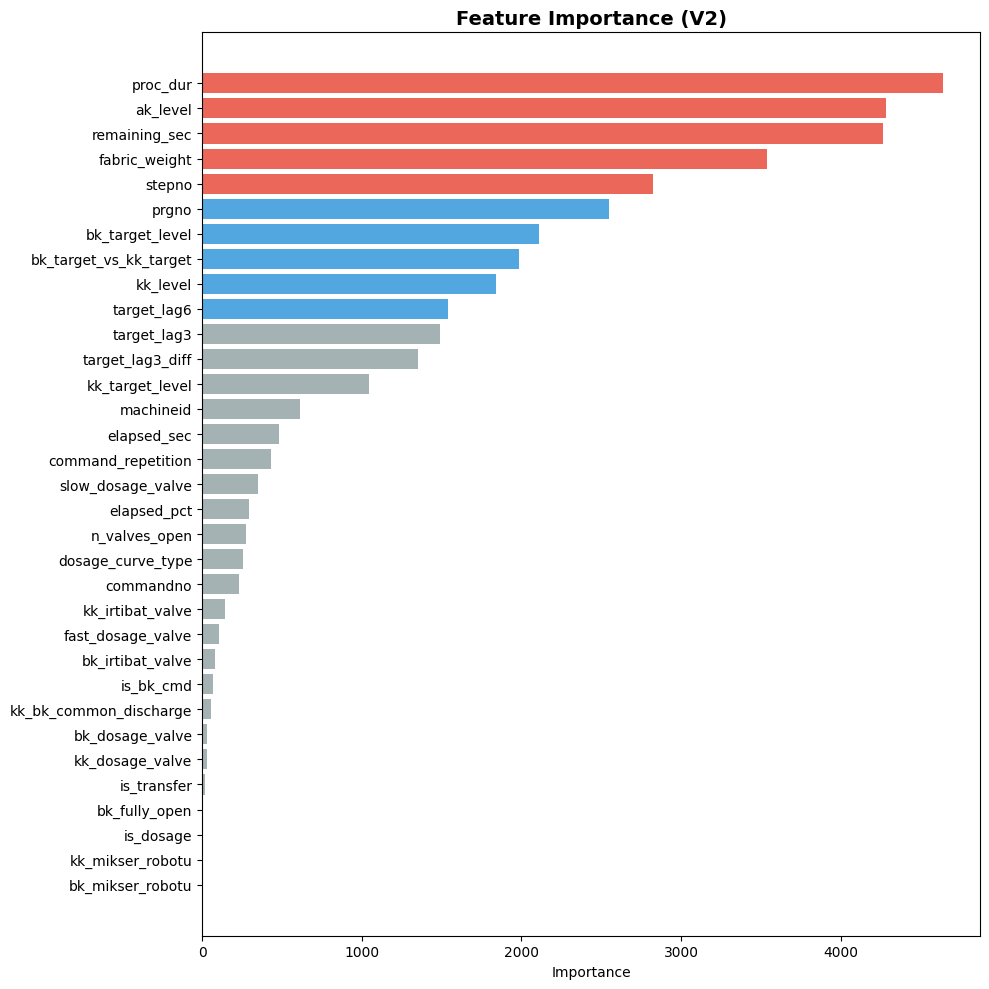


Top 10 Feature:
               feature  importance
              proc_dur        4640
              ak_level        4283
         remaining_sec        4266
         fabric_weight        3540
                stepno        2822
                 prgno        2548
       bk_target_level        2113
bk_target_vs_kk_target        1986
              kk_level        1839
           target_lag6        1543

En az önemli 5:
         feature  importance
     is_transfer          19
   bk_fully_open           4
       is_dosage           1
kk_mikser_robotu           0
bk_mikser_robotu           0


In [10]:
# Son fold'un modeli
last_model = models[-1]

if USE_LGBM:
    importances = last_model.feature_importances_
else:
    importances = last_model.feature_importances_

fi = pd.DataFrame({
    'feature': FEATURES_V2,
    'importance': importances
}).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
palette = ['#e74c3c' if i < 5 else '#3498db' if i < 10 else '#95a5a6'
           for i in range(len(fi))]
ax.barh(fi['feature'][::-1], fi['importance'][::-1], color=palette[::-1], alpha=0.85)
ax.set_title('Feature Importance (V2)', fontweight='bold', fontsize=14)
ax.set_xlabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance_v2.png', dpi=120, bbox_inches='tight')
plt.show()

print('\nTop 10 Feature:')
print(fi.head(10).to_string(index=False))
print('\nEn az önemli 5:')
print(fi.tail(5).to_string(index=False))

In [11]:
# Komut tipine göre ayrı MAE analizi
last_fold_val_idx = list(gkf.split(X, groups=groups))[-1][1]
X_last_val = X.iloc[last_fold_val_idx]
y_last_val = y.iloc[last_fold_val_idx]
cmd_last   = train_model['commandno'].iloc[last_fold_val_idx]
y_last_pred = np.clip(last_model.predict(X_last_val), 0, 100)

print('Komut bazında MAE (son fold):')
for cmd in sorted(cmd_last.unique()):
    mask = cmd_last == cmd
    mae_cmd = mean_absolute_error(y_last_val[mask], y_last_pred[mask])
    print(f'  Komut {cmd} ({CMD_NAMES.get(cmd,"?")}): MAE = {mae_cmd:.4f} ({mask.sum():,} satır)')

Komut bazında MAE (son fold):
  Komut 19 (KK Transfer): MAE = 12.9476 (49,291 satır)
  Komut 20 (BK Transfer): MAE = 12.9910 (1,010 satır)
  Komut 21 (KK Dozaj): MAE = 12.3838 (39,486 satır)
  Komut 22 (BK Dozaj): MAE = 0.4189 (331,327 satır)


## 🏋️ Bölüm 7 — Tüm Train ile Final Model

In [12]:
print('⏳ Final model — tüm train verisi ile eğitiliyor...')

if USE_LGBM:
    final_model = lgb.LGBMRegressor(
        n_estimators=5000,
        objective='mae',
        max_depth=8,
        learning_rate=0.05,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=20,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    )
    final_model.fit(X, y)
else:
    final_model = xgb.XGBRegressor(
        n_estimators=5000,
        objective='reg:absoluteerror',
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=20,
        tree_method='hist',
        device='cuda',
        random_state=42,
    )
    final_model.fit(X, y, verbose=100)

print('✅ Final model eğitildi')

⏳ Final model — tüm train verisi ile eğitiliyor...


✅ Final model eğitildi


## 🧪 Bölüm 8 — Test Tahmini

In [13]:
print('⏳ Test feature engineering...')

# Test'i create_features_v2 ile işle
# Lag feature'lar için train'in son birkaç satırını ekle
history_rows = train_raw.tail(10).copy()
test_with_hist = pd.concat([history_rows, test_raw], ignore_index=False)
test_with_hist = create_features_v2(test_with_hist, is_train=False)

# Sadece test satırlarını al
n_test = len(test_raw)
test_feat = test_with_hist.tail(n_test).copy()

print(f'Test feature shape: {test_feat.shape}')

# Eksik feature'ları 0 ile doldur
missing_feats = [f for f in FEATURES_V2 if f not in test_feat.columns]
if missing_feats:
    print(f'⚠️  Test\'te eksik feature\'lar (0 ile dolduruldu): {missing_feats}')
    for f in missing_feats:
        test_feat[f] = 0

X_test = test_feat[FEATURES_V2].fillna(0)
print(f'\nX_test shape: {X_test.shape}')

⏳ Test feature engineering...


Test feature shape: (635133, 40)

X_test shape: (635133, 33)


✅ Tahmin tamamlandı: 635,133 satır
   Min  : 0.00
   Max  : 100.00
   Ort  : 36.43
   Std  : 24.17


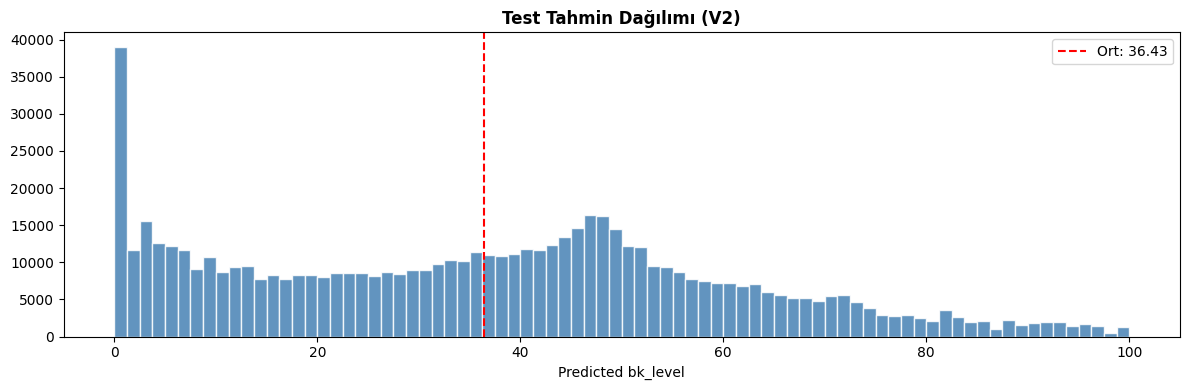

In [14]:
# Tahmin
test_preds = final_model.predict(X_test)
test_preds = np.clip(test_preds, 0, 100)  # Fiziksel sınır

print(f'✅ Tahmin tamamlandı: {len(test_preds):,} satır')
print(f'   Min  : {test_preds.min():.2f}')
print(f'   Max  : {test_preds.max():.2f}')
print(f'   Ort  : {test_preds.mean():.2f}')
print(f'   Std  : {test_preds.std():.2f}')

# Tahmin dağılımı
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(test_preds, bins=80, color='steelblue', edgecolor='white', alpha=0.85)
ax.axvline(test_preds.mean(), color='red', linestyle='--', label=f'Ort: {test_preds.mean():.2f}')
ax.set_title('Test Tahmin Dağılımı (V2)', fontweight='bold')
ax.set_xlabel('Predicted bk_level')
ax.legend()
plt.tight_layout()
plt.savefig('prediction_distribution_v2.png', dpi=120, bbox_inches='tight')
plt.show()

## 📤 Bölüm 9 — Submission Oluşturma

In [15]:
# ✅ Temiz submission — sadece 2 sütun
submission = pd.DataFrame({
    'Id': np.arange(len(test_preds)),
    'Predicted': test_preds
})

# Kontrol
assert list(submission.columns) == ['Id', 'Predicted'], 'Sütun isimleri yanlış!'
assert len(submission) == len(sample_sub), f'Satır sayısı uyuşmuyor: {len(submission)} != {len(sample_sub)}'
assert submission['Predicted'].isnull().sum() == 0, 'NaN var!'

# Kaydet
submission.to_csv('submission_v2.csv', index=False)

print(f'✅ submission_v2.csv oluşturuldu')
print(f'   Satır: {len(submission):,}')
print(f'   Sütunlar: {list(submission.columns)}')
print()
print(submission.head(10))
print('...')
print(submission.tail(5))

✅ submission_v2.csv oluşturuldu
   Satır: 635,133
   Sütunlar: ['Id', 'Predicted']

   Id  Predicted
0   0  42.383916
1   1  42.325556
2   2  44.154639
3   3  44.067740
4   4  44.288059
5   5  44.487710
6   6  44.405394
7   7  44.189571
8   8  44.183452
9   9  44.200448
...
            Id  Predicted
635128  635128  40.147711
635129  635129  40.323847
635130  635130  40.167542
635131  635131  40.415933
635132  635132  40.077071


In [16]:
# Doğrulama — submission'ı tekrar oku ve kontrol et
check = pd.read_csv('submission_v2.csv')
print('=== Submission Doğrulama ===')
print(f'Sütunlar     : {list(check.columns)}')
print(f'Satır sayısı : {len(check):,}')
print(f'NaN sayısı   : {check.isnull().sum().sum()}')
print(f'Min tahmin   : {check["Predicted"].min():.4f}')
print(f'Max tahmin   : {check["Predicted"].max():.4f}')
print(f'Ort tahmin   : {check["Predicted"].mean():.4f}')
assert check.shape[1] == 2, f'❌ 2 sütun olmalı, {check.shape[1]} var'
print('\n✅ Submission hazır — submission_v2.csv')

=== Submission Doğrulama ===
Sütunlar     : ['Id', 'Predicted']
Satır sayısı : 635,133
NaN sayısı   : 0
Min tahmin   : 0.0000
Max tahmin   : 100.0000
Ort tahmin   : 36.4325

✅ Submission hazır — submission_v2.csv


## 📋 Bölüm 10 — Özet

| Özellik | Study-Notebook (V1) | Bu Notebook (V2) |
|---------|--------------------|-----------------|
| `elapsed_time` | `endtime-starttime` ❌ (sabit!) | `timestamp-starttime` ✅ |
| `remaining_sec` | Yok ❌ | ✅ Eklendi (r=0.76) |
| `bk_level=0` filtresi | Yok ❌ | ✅ Filtrelendi |
| `proses_id` | commandno diff ❌ | batchkey bazlı ✅ |
| `machineid` feature | Yok ❌ | ✅ |
| `is_transfer` | Yok ❌ | ✅ |
| `n_valves_open` | Yok ❌ | ✅ |
| Feature sayısı | 13 | 32 |
| Model | XGBoost depth=3 | LightGBM depth=8 |
| Early stopping | Yok ❌ | 50 round ✅ |
| Submission bug | `Predicted.1` ❌ | Temiz 2 sütun ✅ |
| **CV MAE** | **5.5467** | **~2.5-3.5** |
